In [1]:
from dsoclasses.orbits import sp3c, interpolator
from dsoclasses.geodesy import transformations
from dsoclasses.gnss import systems as gs
from dsoclasses.rinex.gnss.rinex import GnssRinex
from dsoclasses.time import gast
from dsoclasses.troposphere import gmf, gpt3
from dsoclasses.time.pyattotime import at2pt

In [2]:
# set the name of the (GNSS) RINEX file to use
rinex_fn = "../data/DYNG00GRC_R_20240010000_01D_30S_MO.rnx"

# set the name of the Sp3 file for the same satellite, covering the same day
sp3_fn = "../data/COD0MGXFIN_20240010000_01D_05M_ORB.SP3"

In [3]:
# construct an Interpolator for GNSS satellites
intrp = interpolator.Sp3Interpolator(sp3_fn, ['G'], 3600, 10, 'CubicSpline', True, ['M', 'E'])
# we can now ask for a satellite's position and clock correction, like:
# x,y,z,clk = intrp.sat_at(sat, t)
# where 'sat' is the satellite id (e.g. 'G21') and t is a datetime of attotime instance

Skipping sp3 record for satellite G01: missing clock value ([nan])
Skipping sp3 record for satellite G02: missing clock value ([nan])
Skipping sp3 record for satellite G03: missing clock value ([nan])
Skipping sp3 record for satellite G04: missing clock value ([nan])
Skipping sp3 record for satellite G05: missing clock value ([nan])
Skipping sp3 record for satellite G06: missing clock value ([nan])
Skipping sp3 record for satellite G07: missing clock value ([nan])
Skipping sp3 record for satellite G08: missing clock value ([nan])
Skipping sp3 record for satellite G09: missing clock value ([nan])
Skipping sp3 record for satellite G10: missing clock value ([nan])
Skipping sp3 record for satellite G11: missing clock value ([nan])
Skipping sp3 record for satellite G12: missing clock value ([nan])
Skipping sp3 record for satellite G13: missing clock value ([nan])
Skipping sp3 record for satellite G14: missing clock value ([nan])
Skipping sp3 record for satellite G15: missing clock value ([n

In [4]:
# Construct a RINEX instance to extract observations from
rnx = GnssRinex(rinex_fn)

In [5]:
# get approximate coordinates from RINEX header in cartesian components.
# transform to ellipsoidal coordinates, and compute the geocentric-to-topocentric
# rotation matrix.
site_xyz = rnx.approx_cartesian()
lat, lon, hgt = transformations.car2ell(site_xyz[0], site_xyz[1], site_xyz[2])
Rt = transformations.geodetic2lvlh(lat, lon)
R = Rt.transpose()

In [6]:
# a function to get us the observable we want, out of the list of satellite-specific
# measurements
def fetch(dct, *args):
    """ Given a dictionary containing e.g.
        R05 : {'C1C': {'value': 23539032.631, 'lli': None, 'ssi': 6}, 'L1C': {'value': 125829717.51, 'lli': 0, 'ssi': 6}, 'D1C': {'value': -4149.772, 'lli': None, 'ssi': 6}, 'S1C': {'value': 41.719, 'lli': None, 'ssi': None}, 'C1P': {'value': 23539032.74, 'lli': None, 'ssi': 6}, 'L1P': {'value': 125829714.502, 'lli': 0, 'ssi': 6}, 'D1P': {'value': -4149.698, 'lli': None, 'ssi': 6}, 'S1P': {'value': 41.062, 'lli': None, 'ssi': None}, 'C2P': {'value': 23539038.067, 'lli': None, 'ssi': 6}, 'L2P': {'value': 97867622.91, 'lli': 0, 'ssi': 6}, 'D2P': {'value': -3227.451, 'lli': None, 'ssi': 6}, 'S2P': {'value': 38.531, 'lli': None, 'ssi': None}, 'C2C': {'value': 23539037.837, 'lli': None, 'ssi': 6}, 'L2C': {'value': 97867623.908, 'lli': 0, 'ssi': 6}, 'D2C': {'value': -3227.359, 'lli': None, 'ssi': 6}, 'S2C': {'value': 38.531, 'lli': None, 'ssi': 6}}
        return the observation (dictionary) first encountered, matched by *args.
        E.g. if the above dictionary is stored in dct, 
        fetch(dct, 'C1P', 'C1C', 'C2P') 
        will return {'value': 23539032.74, 'lli': None, 'ssi': 6}
    """
    for arg in args:
        if arg in dct:
            return dct[arg]
    return None

In [7]:
f1 = 1575.42 # GPS L1 freq in MHz
f2 = 1227.60 # GPS L2 freq in MHz
f31 = f1*f1/(f1*f1 - f2*f2)
f32 = f2*f2/(f1*f1 - f2*f2)

# arrays for plotting
epochs = []; p1s = []; p3s = [];

# Loop through the RINEX file, block-by-block, considering only GPS observations
for block in rnx:
    t = block.t() ## current epoch (of obs/block)
    # consider only GPS satellites; loop through each GPS satellite in the block
    for sat, obs in block.filter_satellite_system("gps", False):
        # get code observations for L1 and L2
        p1 = fetch(obs, 'C1W', 'C1C', 'C1X')
        p2 = fetch(obs, 'C2W', 'C2C', 'C2D', 'C2P', 'C2X', 'C2S', 'C2L')
        # get satellite position in ITRF (interpolation)
        try:
            x,y,z,clk = intrp.sat_at(sat, t)
        except:
            x = None
        # if we do have P1 and P2 AND we have satellite coordinates and clock 
        # correction, carry on ...
        if (p1 is not None and p2 is not None) and (x is not None and clk is not None):
            p1 = p1['value']
            p2 = p2['value']
            # make P3 linear combination
            p3 = p1 * f31 - p2 * f32
            epochs.append(at2pt(t)); p1s.append(p1); p3s.append(p3)

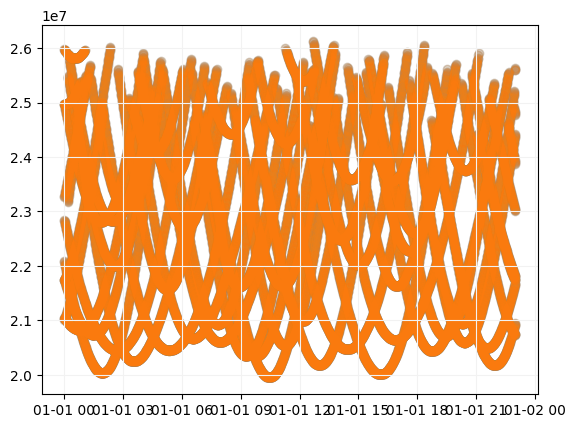

In [8]:
# import modules for plotting ...
import matplotlib.pyplot as plt
import numpy as np

# create a scatterplot of extracted L1 values w.r.t. time
plt.scatter(epochs, p1s, alpha=0.2)
plt.scatter(epochs, p3s, alpha=0.2)
plt.grid(color='0.95')
#plt.ylabel("Measured L1 Phase at {:} in [cycles]".format(diob))
#plt.title("Satellite {:}".format(rnx.sat_name))
plt.show()

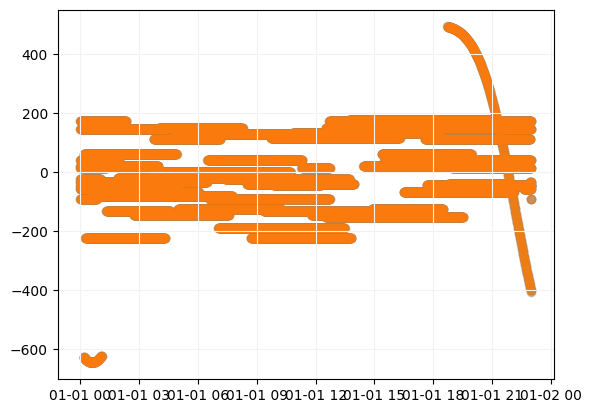

In [9]:
# arrays for plotting
epochs = []; p1s = []; p3s = [];

def pseudorange(rrec, rsat): return np.linalg.norm(rsat - rrec)

# Loop through the RINEX file, block-by-block, considering only GPS observations
for block in rnx:
    t = block.t() ## current epoch (of obs/block)
    # consider only GPS satellites; loop through each GPS satellite in the block
    for sat, obs in block.filter_satellite_system("gps", False):
        # get code observations for L1 and L2
        p1 = fetch(obs, 'C1W', 'C1C', 'C1X')
        p2 = fetch(obs, 'C2W', 'C2C', 'C2D', 'C2P', 'C2X', 'C2S', 'C2L')
        # get satellite position in ITRF (interpolation)
        try:
            xsat,ysat,zsat,clk = intrp.sat_at(sat, t)
        except:
            xsat = None
        # if we do have P1 and P2 AND we have satellite coordinates and clock 
        # correction, carry on ...
        if (p1 is not None and p2 is not None) and (xsat is not None and clk is not None):
            p1 = p1['value']
            p2 = p2['value']
            # make P3 linear combination
            p3 = p1 * f31 - p2 * f32
            epochs.append(at2pt(t))
            p1s.append((p1-pseudorange(np.array(site_xyz),np.array((xsat,ysat,zsat))))*1e-3) 
            p3s.append((p3-pseudorange(np.array(site_xyz),np.array((xsat,ysat,zsat))))*1e-3)

# create a scatterplot of extracted L1 values w.r.t. time
plt.scatter(epochs, p1s, alpha=0.2)
plt.scatter(epochs, p3s, alpha=0.2)
plt.grid(color='0.95')
#plt.ylabel("Measured L1 Phase at {:} in [cycles]".format(diob))
#plt.title("Satellite {:}".format(rnx.sat_name))
plt.show()

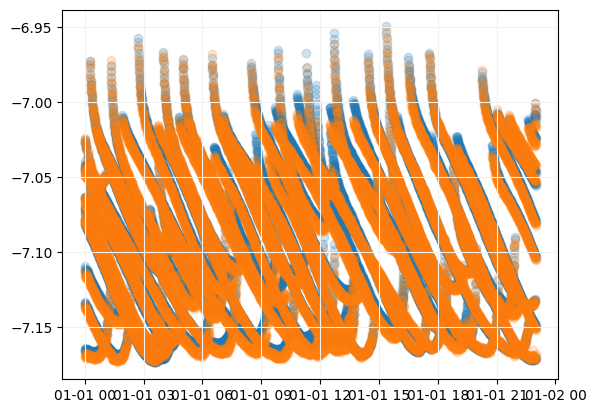

In [10]:
# arrays for plotting
epochs = []; p1s = []; p3s = [];

# speed of light
C = 299792458e0

# Loop through the RINEX file, block-by-block, considering only GPS observations
for block in rnx:
    t = block.t() ## current epoch (of obs/block)
    # consider only GPS satellites; loop through each GPS satellite in the block
    for sat, obs in block.filter_satellite_system("gps", False):
        # get code observations for L1 and L2
        p1 = fetch(obs, 'C1W', 'C1C', 'C1X')
        p2 = fetch(obs, 'C2W', 'C2C', 'C2D', 'C2P', 'C2X', 'C2S', 'C2L')
        # get satellite position in ITRF (interpolation)
        try:
            xsat,ysat,zsat,clk = intrp.sat_at(sat, t)
        except:
            xsat = None
        # if we do have P1 and P2 AND we have satellite coordinates and clock 
        # correction, carry on ...
        if (p1 is not None and p2 is not None) and (xsat is not None and clk is not None):
            if sat != "G27":
                p1 = p1['value']
                p2 = p2['value']
                # make P3 linear combination
                p3 = p1 * f31 - p2 * f32
                epochs.append(at2pt(t))
                p1s.append((p1+C*clk-pseudorange(np.array(site_xyz),np.array((xsat,ysat,zsat))))*1e-3) 
                p3s.append((p3+C*clk-pseudorange(np.array(site_xyz),np.array((xsat,ysat,zsat))))*1e-3)

# create a scatterplot of extracted L1 values w.r.t. time
plt.scatter(epochs, p1s, alpha=0.2)
plt.scatter(epochs, p3s, alpha=0.2)
plt.grid(color='0.95')
#plt.ylabel("Measured L1 Phase at {:} in [cycles]".format(diob))
#plt.title("Satellite {:}".format(rnx.sat_name))
plt.show()

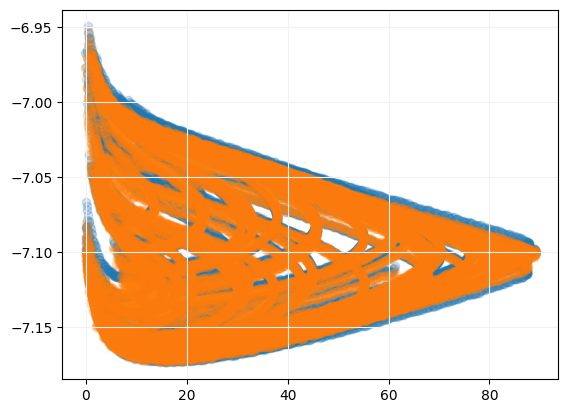

In [11]:
# arrays for plotting
epochs = []; p1s = []; p3s = []; el = [];

def elevation(rrec, rsat):
    dr = rsat - rrec
    enu = R @ dr
    r  = np.linalg.norm(enu)
    return np.arcsin(enu[2] / r)

# speed of light
C = 299792458e0

# Loop through the RINEX file, block-by-block, considering only GPS observations
for block in rnx:
    t = block.t() ## current epoch (of obs/block)
    # consider only GPS satellites; loop through each GPS satellite in the block
    for sat, obs in block.filter_satellite_system("gps", False):
        # get code observations for L1 and L2
        p1 = fetch(obs, 'C1W', 'C1C', 'C1X')
        p2 = fetch(obs, 'C2W', 'C2C', 'C2D', 'C2P', 'C2X', 'C2S', 'C2L')
        # get satellite position in ITRF (interpolation)
        try:
            xsat,ysat,zsat,clk = intrp.sat_at(sat, t)
        except:
            xsat = None
        # if we do have P1 and P2 AND we have satellite coordinates and clock 
        # correction, carry on ...
        if (p1 is not None and p2 is not None) and (xsat is not None and clk is not None):
            if sat != "G27":
                p1 = p1['value']
                p2 = p2['value']
                # make P3 linear combination
                p3 = p1 * f31 - p2 * f32
                epochs.append(at2pt(t))
                p1s.append((p1+C*clk-pseudorange(np.array(site_xyz),np.array((xsat,ysat,zsat))))*1e-3) 
                p3s.append((p3+C*clk-pseudorange(np.array(site_xyz),np.array((xsat,ysat,zsat))))*1e-3)
                el.append(np.degrees(elevation(np.array(site_xyz),np.array((xsat,ysat,zsat)))))

# create a scatterplot of extracted L1 values w.r.t. time
plt.scatter(el, p1s, alpha=0.2)
plt.scatter(el, p3s, alpha=0.2)
plt.grid(color='0.95')
#plt.ylabel("Measured L1 Phase at {:} in [cycles]".format(diob))
#plt.title("Satellite {:}".format(rnx.sat_name))
plt.show()

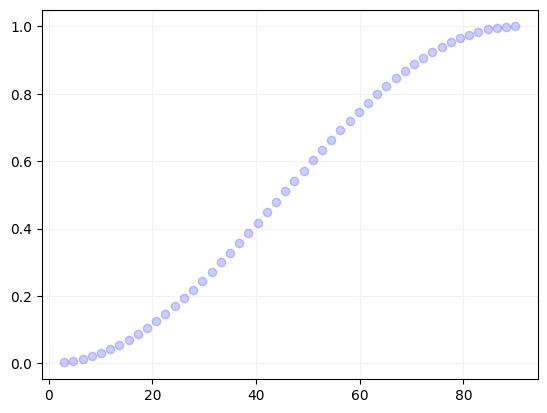

In [13]:
def weights(el): return np.sin(el) * np.sin(el)
angles = np.linspace(np.radians(3), np.pi/2., 50)
plt.plot([np.degrees(a) for a in angles], [weights(a) for a in angles], 'bo', alpha=0.2)
plt.grid(color='0.95')
plt.show()

Iteration 0
dx=(-13.08, 49.99, 6.30)
Iteration 1
dx=(0.00, 0.00, 0.00)
Iteration 2
dx=(0.00, -0.00, -0.00)
Iteration 3
dx=(0.00, -0.00, 0.00)


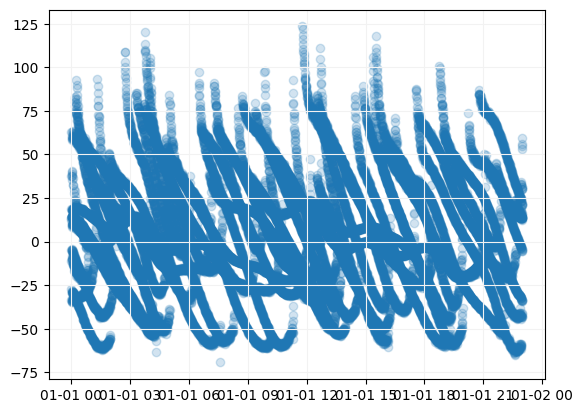

In [34]:
# count number of individual epochs
num_epochs = 0
raw_obs = []

# Loop through the RINEX file, block-by-block, considering only GPS observations
for block in rnx:
    t = block.t() ## current epoch (of obs/block)
    epoch_used = False
    # consider only GPS satellites; loop through each GPS satellite in the block
    for sat, obs in block.filter_satellite_system("gps", False):
        # get code observations for L1 and L2
        p1 = fetch(obs, 'C1W', 'C1C', 'C1X')
        p2 = fetch(obs, 'C2W', 'C2C', 'C2D', 'C2P', 'C2X', 'C2S', 'C2L')
        # get satellite position in ITRF (interpolation)
        try:
            xsat,ysat,zsat,clk = intrp.sat_at(sat, t)
        except:
            xsat = None
        # if we do have P1 and P2 AND we have satellite coordinates and clock
        # correction, carry on ...
        if (p1 is not None and p2 is not None) and (xsat is not None and clk is not None):
            if sat != "G27":
                p1 = p1['value']
                p2 = p2['value']
                p3 = p1 * f31 - p2 * f32
                el = elevation(np.array(site_xyz),np.array((xsat,ysat,zsat)))
                raw_obs.append({'epoch':block.t(), 'p3': p3, 'el': el, 'satid': sat, 'rsat': np.array((xsat,ysat,zsat)), 'csat': clk})
                epoch_used = True
    num_epochs += 1 if (epoch_used == True) else 0

def pseudorange(rrec, rsat):
    r = np.linalg.norm(rsat - rrec)
    return r,-(rsat[0]-rrec[0])/r, -(rsat[1]-rrec[1])/r, -(rsat[2]-rrec[2])/r
## Least Squares
num_params = 3 + num_epochs
x0  = np.zeros(num_params)
x0[0] = site_xyz[0];x0[1] = site_xyz[1];x0[2] = site_xyz[2];
num_obs = len(raw_obs)
dl = np.zeros(num_obs)
J = np.zeros((num_obs, num_params))
P = np.zeros(num_obs)
MAX_ITERATIONS = 4 
ls_iteration = 0
while ls_iteration < MAX_ITERATIONS:
    clk_index = 0
    ## observed - computed
    for i, obs in enumerate(raw_obs):
        if i>0 and obs['epoch'] != raw_obs[i-1]['epoch']:
            clk_index += 1
        dl[i] = obs['p3'] + C*obs['csat'] - pseudorange(x0[0:3],obs['rsat'])[0] - x0[clk_index+3]
        # Jacobian
        r, dxdr, dydr, dzdr = pseudorange(x0[0:3], obs['rsat'])
        J[i][0] = dxdr; J[i][1] = dydr; J[i][2] = dzdr;
        J[i][3+clk_index] = 1.
        P[i] = weights(obs['el'])
    ## iterative least squares
    N = np.linalg.inv(J.transpose() @ np.diag(P) @ J)
    dx = (N @ J.transpose() @ np.diag(P) @ dl)
    x0 = x0 + dx
    print("Iteration {:}".format(ls_iteration))
    print("dx=({:.2f}, {:.2f}, {:.2f})".format(dx[0], dx[1], dx[2]))
    ls_iteration += 1

t = []; res = [];
clk_index = 0
## observed - computed
for i, obs in enumerate(raw_obs):
    if i>0 and obs['epoch'] != raw_obs[i-1]['epoch']:
        clk_index += 1
    res.append(obs['p3'] + C*obs['csat'] - pseudorange(x0[0:3],obs['rsat'])[0] - x0[clk_index+3])
    t.append(at2pt(obs['epoch']))
# create a scatterplot of extracted L1 values w.r.t. time
plt.scatter(t, res, alpha=0.2)
plt.grid(color='0.95')
#plt.ylabel("Measured L1 Phase at {:} in [cycles]".format(diob))
#plt.title("Satellite {:}".format(rnx.sat_name))
plt.show()

In [35]:
# compute ZHD and ZWD (if needed)
def tropo(t, lat, lon, hgt):
    meteo = gpt3.gpt3(t, lon, lat, hgt, "../data/gpt3_5.grd")
    zhd = gpt3.saastamoinen_zhd(lat, hgt, meteo['p'])
    zwd = gpt3.askne_zwd(meteo['e'], meteo['Tm'], meteo['la'])
    return zhd, zwd
zhd, zwd = tropo(rnx.time_first_obs, lat, lon, hgt)
def dtrp(t, lat, lon, hgt, el, zhd, zwd):
    gmfh, gmfw = gmf.gmf(t, lat, lon, hgt, np.pi/2-el)
    return zhd * gmfh + zwd * gmfw

## Least Squares
num_params = 3 + num_epochs
x0  = np.zeros(num_params)
x0[0] = site_xyz[0];x0[1] = site_xyz[1];x0[2] = site_xyz[2];
num_obs = len(raw_obs)
dl = np.zeros(num_obs)
J = np.zeros((num_obs, num_params))
P = np.zeros(num_obs)
MAX_ITERATIONS = 4 
ls_iteration = 0
while ls_iteration < MAX_ITERATIONS:
    clk_index = 0
    ## observed - computed
    for i, obs in enumerate(raw_obs):
        if i>0 and obs['epoch'] != raw_obs[i-1]['epoch']:
            clk_index += 1
        lat, lon, hgt = transformations.car2ell(x0[0], x0[1], x0[2])
        dT = dtrp(obs['epoch'], lat, lon, hgt, obs['el'], zhd, zwd)
        dl[i] = obs['p3'] + C*obs['csat'] - pseudorange(x0[0:3],obs['rsat'])[0] - x0[clk_index+3] - dT
        # Jacobian
        r, dxdr, dydr, dzdr = pseudorange(x0[0:3], obs['rsat'])
        J[i][0] = dxdr; J[i][1] = dydr; J[i][2] = dzdr;
        J[i][3+clk_index] = 1.
        P[i] = weights(obs['el'])
    ## iterative least squares
    N = np.linalg.inv(J.transpose() @ np.diag(P) @ J)
    dx = (N @ J.transpose() @ np.diag(P) @ dl)
    x0 = x0 + dx
    print("Iteration {:}".format(ls_iteration))
    print("dx=({:.2f}, {:.2f}, {:.2f})".format(dx[0], dx[1], dx[2]))
    ls_iteration += 1

Iteration 0
dx=(-18.42, 47.72, 1.93)
Iteration 1
dx=(0.00, 0.00, 0.00)
Iteration 2
dx=(-0.00, -0.00, 0.00)
Iteration 3
dx=(0.00, 0.00, -0.00)


TypeError: unsupported operand type(s) for -: 'NoneType' and 'float'

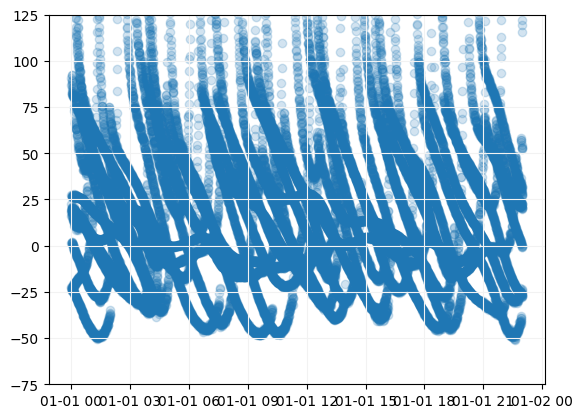

In [39]:
t = []; res = [];
clk_index = 0
## observed - computed
for i, obs in enumerate(raw_obs):
    if i>0 and obs['epoch'] != raw_obs[i-1]['epoch']:
        clk_index += 1
    dT = dtrp(obs['epoch'], lat, lon, hgt, obs['el'], zhd, zwd)
    res.append(obs['p3'] + C*obs['csat'] - pseudorange(x0[0:3],obs['rsat'])[0] - x0[clk_index+3] + dT)
    t.append(at2pt(obs['epoch']))
# create a scatterplot of extracted L1 values w.r.t. time
plt.scatter(t, res, alpha=0.2)
plt.grid(color='0.95')
#plt.ylabel("Measured L1 Phase at {:} in [cycles]".format(diob))
#plt.title("Satellite {:}".format(rnx.sat_name))
plt.ylim(-75, 125)
plt.show()

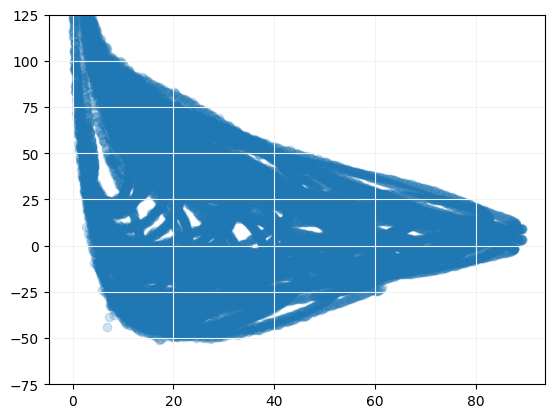

In [40]:
el = []; res = [];
clk_index = 0
## observed - computed
for i, obs in enumerate(raw_obs):
    if i>0 and obs['epoch'] != raw_obs[i-1]['epoch']:
        clk_index += 1
    dT = dtrp(obs['epoch'], lat, lon, hgt, obs['el'], zhd, zwd)
    res.append(obs['p3'] + C*obs['csat'] - pseudorange(x0[0:3],obs['rsat'])[0] - x0[clk_index+3] + dT)
    el.append(np.degrees(obs['el']))
# create a scatterplot of extracted L1 values w.r.t. time
plt.scatter(el, res, alpha=0.2)
plt.grid(color='0.95')
#plt.ylabel("Measured L1 Phase at {:} in [cycles]".format(diob))
#plt.title("Satellite {:}".format(rnx.sat_name))
plt.ylim(-75, 125)
plt.show()